# Processing the Linguistic data

This uses the "OCSEAN_language_collection_overview_April_25.xlsx" data and CleanedData folder provided by Monika.


## Preamble

We import some useful libraries that we will use further down.

In [1]:
import pandas as pd # Pandas is the most common "data frame", i.e. Excel-sheet reader
import os # os = operating system; we use this for accessing files on the computer
import re

In [2]:
os.getcwd() # Which directory are we in? It should contain the file and folder described above inside it.

'/Users/madjl/GoogleDrive/University/OCSEAN-2025/RESEARCH'

## Reading and checking data

We will read the main excel overview file using pandas. It is a simple call, but to make life easier we will choose not to treat missing (empty) cells specially; they are just an empty string. This is a bad idea for numerical values but can be useful for strings.

In [3]:
collectionsheet=pd.read_excel("OCSEAN_language_collection_overview_April_25.xlsx",na_filter=False)  
# We don't detect NA values, and instead treat them as they are (empty strings)

In [4]:
collectionsheet.head() # Look at the top few values

,Language_BasedOnMasterSheet,ISO code (from Original_FileName),COUNTRY,LocalWordsPresent,QC_done,AddedToTheUnitedLanguagesMasterFile,Comment,Separator,Mismatches_Eng,Mismatches_IndoOrTaga,Original_FileName,QC_FileName,Google Map Coordinate
0,Abui Bunggeta,ABZ,Indonesia,604,Yes,Yes,Some English and or Indonesian words in this l...,", and ; and ~ (?). Only used , and ;",41,87,OCSEAN-ABZ_20240605-BUNGGETA_WORDLIST.xlsx,OCSEAN-ABZ_20240605-BUNGGETA_WORDLIST_PostQC.xlsx,
1,Abui Kilakawada,ABZ,Indonesia,604,Yes,Yes,English and English Elicitation notes complete...,", and ; and ~ (?). Only used , and ;",41,87,OCSEAN-ABZ_20240606-KILAKAWADA_WORDLIST.xlsx,OCSEAN-ABZ_20240606-KILAKAWADA_WORDLIST_PostQC...,
2,Abui Mobyetang,ABZ,Indonesia,602,Yes,Yes,English Elicitation = English actually. Some E...,", and ; and ~ (?). Only used , and ;",41,87,OCSEAN-ABZ_20240610-MOBYETANG_WORDLIST.xlsx,OCSEAN-ABZ_20240610-MOBYETANG_WORDLIST_PostQC....,
3,Abui Pelman,ABZ,Indonesia,602,Yes,Yes,English Elicitation = English actually. Some E...,", and ; and ~ (?). Only used , and ;",41,87,OCSEAN-ABZ_20240610-PELMAN_WORDLIST.xlsx,OCSEAN-ABZ_20240610-PELMAN_WORDLIST_PostQC.xlsx,
4,Abui Takalelang,ABZ,Indonesia,293,NO,NO,There is no orthography. Only few hundred IPAs...,,0,0,OCSEAN-ABZ_20220715-TAKALELANG_WORDLIST.xlsx,NA,


## Convert the "google map co-ordinate" to simple longitute and latitute columns

The co-ordinate information is in at least two formats so a little tricky to analyse. I asked ChatGPT:

`I have a pandas dataframe containing longitude and latitute in a single free text column with some variation. Some examples are:

9°15'55.8"N 125°33'33.5"E

11.677084170029522, 122.32238044457551

7°53'43.6"N 122°54'57.6"E

I would like to process this column to reliably obtain a longitude and a latitude column. What is the easiest way to do that?`

It gave me the following solution. This uses "regular expressions" (Regexp) to figure out the format, and turn this into a simple number. It handles the challenge of some formats having "N=North" or "S=South" (E/W) and others having +/- to indicate this.

In [5]:
def dms_to_dd(degrees, minutes, seconds, direction):
    dd = float(degrees) + float(minutes)/60 + float(seconds)/3600
    if direction in ['S', 'W']:
        dd *= -1
    return dd

def parse_location(text):
    # Check for decimal degrees format
    decimal_match = re.match(r'\s*(-?\d+(?:\.\d+)?)\s*,\s*(-?\d+(?:\.\d+)?)\s*', text)
    if decimal_match:
        lat = float(decimal_match.group(1))
        lon = float(decimal_match.group(2))
        return lat, lon

    # Match DMS format
    dms_regex = re.findall(r"(\d+)[°](\d+)'(\d+(?:\.\d+)?)\"?([NSEW])", text)
    if len(dms_regex) == 2:
        lat = dms_to_dd(*dms_regex[0])
        lon = dms_to_dd(*dms_regex[1])
        return lat, lon

    return None, None  # Fallback if format doesn't match

In [6]:
# Apply parsing
collectionsheet[['latitude', 'longitude']] = collectionsheet['Google Map Coordinate'].apply(lambda x: pd.Series(parse_location(x)))
collectionsheet.tail()

,Language_BasedOnMasterSheet,ISO code (from Original_FileName),COUNTRY,LocalWordsPresent,QC_done,AddedToTheUnitedLanguagesMasterFile,Comment,Separator,Mismatches_Eng,Mismatches_IndoOrTaga,Original_FileName,QC_FileName,Google Map Coordinate,latitude,longitude
117,Umajamnon,NA,the Phillipines,NA,NA,NA,NA,NA,NA,NA,NA,NA,,NaN,NaN
118,Umbu-Ungu (Andelale),NA,Papua New Guinea,NA,NA,NA,NA,NA,NA,NA,NA,NA,,NaN,NaN
119,Waray,WAR,the Phillipines,1178,Yes,Not yet,"English Tagalog available, no Indonesian. No s...",space? Didn’t separate,0,1,OCSEAN-WAR_20240407-WORDLIST_1TO1228.xlsx,OCSEAN-WAR_20240407-WORDLIST_1TO1228_PostQC.xlsx,"12.312908225545875, 125.01703265863979",12.312908,125.017033
120,Wersing Pantai Selatan,NA,Indonesia,NA,NA,NA,NA,NA,NA,NA,NA,NA,,NaN,NaN
121,Yakan,YKA,the Phillipines,1129,Yes,Not Yet,"Lowered cases, Indonesian available. English/I...",", (and space?)",0,0,OCSEAN-YKA_20240324-WORDLIST_1TO1228.xlsx,OCSEAN-YKA_20240324-WORDLIST_1TO1228_PostQC.xlsx,"6.898960, 122.087217",6.898960,122.087217


Our first serious code. Here we are going to add a new column called "QCFileExists" that is 'True' if we find a QC'd file, or 'False' if we don't.

Note that if you uncomment the "print" statements, you will get a long description of which files exist. If we'd kept NA values, we'd have to treat them specially here.

## Making a final list of languages to keep

In [151]:
collectionsheet["QCFileExists"] = False
collectionsheet["QCFileUpdated"] = False
collectionsheet["fullfile"] = ""
for id in collectionsheet.index:
    f=collectionsheet.at[id,"QC_FileName"]
    fedit="edited-"+f
    fullfile=os.path.join("CleanedFiles-v1.1",fedit)
    if(os.path.isfile(fullfile)):
        print("Found update for",fullfile)
        collectionsheet.at[id,"QCFileUpdated"]=True
        collectionsheet.at[id, "QCFileExists"]=True
        collectionsheet.at[id,"fullfile"] =fullfile
    else:
        fullfile=os.path.join("CleanedFiles",f)
        if(os.path.isfile(fullfile)):
            collectionsheet.at[id, "QCFileExists"]=True
            collectionsheet.at[id,"fullfile"] =fullfile

Found update for CleanedFiles-v1.1/edited-OCSEAN-ATZ_20240123-WORDLIST_1TO1228_PostQC.xlsx
Found update for CleanedFiles-v1.1/edited-OCSEAN-ATM_20240323-WORDLIST_01TO1228partial(1)_PostQC.xlsx
Found update for CleanedFiles-v1.1/edited-OCSEAN-CEB_20240325-WORDLIST_1TO1228_PostQC.xlsx
Found update for CleanedFiles-v1.1/edited-OCSEAN-ENO_20220712-WORDLIST_PostQC.xlsx
Found update for CleanedFiles-v1.1/edited-OCSEAN-HIL_20220813-WORDLIST_1TO1228_PostQC.xlsx
Found update for CleanedFiles-v1.1/edited-OCSEAN-IVV_20240330-WORDLIST_ISABTANGEN_1TO1228_PostQC.xlsx
Found update for CleanedFiles-v1.1/edited-OCSEAN-IVV_20240316-WORDLIST_ITBAYATEN_1TO1228.xlsx
Found update for CleanedFiles-v1.1/edited-OCSEAN-KNE_20240405-WORDLIST_1TO1228_PostQC.xlsx
Found update for CleanedFiles-v1.1/edited-OCSEAN-PAM_20240130-WORDLIST_1TO1228_PostQC.xlsx
Found update for CleanedFiles-v1.1/edited-OCSEAN-KRJ_20240325-WORDLIST_1TO1228_PostQC.xlsx
Found update for CleanedFiles-v1.1/edited-OCSEAN-MHP_20240620-WORDLIST_BU

In [152]:
collectionsheet["QCFileUpdated"].value_counts()

QCFileUpdated
False    109
True      13
Name: count, dtype: int64

In [153]:
# How many from each country?
collectionsheet["COUNTRY"].value_counts()

COUNTRY
the Phillipines     73
Indonesia           48
Papua New Guinea     1
Name: count, dtype: int64

Now we do some checking. How many values do we get to Use, and how many are missing?

In [154]:
collectionsheet["QCFileExists"].value_counts()

QCFileExists
True     74
False    48
Name: count, dtype: int64

In [155]:
# If we had kept na values, we could count them like this
pd.isna(collectionsheet["QC_FileName"]).value_counts()

QC_FileName
False    122
Name: count, dtype: int64

In [156]:
# This is a dataframe of the languages we cannot find a file for
brokenrecords=(collectionsheet["QCFileExists"]==False)
brokensheet=collectionsheet.loc[brokenrecords,:]
brokensheet.head()

,Language_BasedOnMasterSheet,ISO code (from Original_FileName),COUNTRY,LocalWordsPresent,QC_done,AddedToTheUnitedLanguagesMasterFile,Comment,Separator,Mismatches_Eng,Mismatches_IndoOrTaga,...,"(101, QCFileUpdated)","(102, QCFileUpdated)","(108, QCFileUpdated)","(109, QCFileUpdated)","(111, QCFileUpdated)","(112, QCFileUpdated)","(113, QCFileUpdated)","(117, QCFileUpdated)","(120, QCFileUpdated)",fullfile
4,Abui Takalelang,ABZ,Indonesia,293,NO,NO,There is no orthography. Only few hundred IPAs...,,0,0,...,True,True,True,True,True,True,True,True,True,
5,Abui Takalelang,NA,Indonesia,NA,NA,NA,NA,NA,NA,NA,...,True,True,True,True,True,True,True,True,True,
6,Abui Takalelang,NA,Indonesia,NA,NA,NA,NA,NA,NA,NA,...,True,True,True,True,True,True,True,True,True,
8,Adang,NA,Indonesia,NA,NA,NA,NA,NA,NA,NA,...,True,True,True,True,True,True,True,True,True,
9,Agta,AGT,the Phillipines,952,"Yes, but not ideal",Yes,There seems to be an issue with the removal of...,", and /",13,65,...,True,True,True,True,True,True,True,True,True,


In [157]:
# This is a dataframe of the languages we CAN find a file for
cleansheet=collectionsheet.copy().loc[(collectionsheet["QCFileExists"]==True),:]
cleansheet["Language_BasedOnMasterSheet"] = cleansheet["Language_BasedOnMasterSheet"].apply(lambda x: x.strip())
cleansheet.head()

,Language_BasedOnMasterSheet,ISO code (from Original_FileName),COUNTRY,LocalWordsPresent,QC_done,AddedToTheUnitedLanguagesMasterFile,Comment,Separator,Mismatches_Eng,Mismatches_IndoOrTaga,...,"(101, QCFileUpdated)","(102, QCFileUpdated)","(108, QCFileUpdated)","(109, QCFileUpdated)","(111, QCFileUpdated)","(112, QCFileUpdated)","(113, QCFileUpdated)","(117, QCFileUpdated)","(120, QCFileUpdated)",fullfile
0,Abui Bunggeta,ABZ,Indonesia,604,Yes,Yes,Some English and or Indonesian words in this l...,", and ; and ~ (?). Only used , and ;",41,87,...,True,True,True,True,True,True,True,True,True,CleanedFiles/OCSEAN-ABZ_20240605-BUNGGETA_WORD...
1,Abui Kilakawada,ABZ,Indonesia,604,Yes,Yes,English and English Elicitation notes complete...,", and ; and ~ (?). Only used , and ;",41,87,...,True,True,True,True,True,True,True,True,True,CleanedFiles/OCSEAN-ABZ_20240606-KILAKAWADA_WO...
2,Abui Mobyetang,ABZ,Indonesia,602,Yes,Yes,English Elicitation = English actually. Some E...,", and ; and ~ (?). Only used , and ;",41,87,...,True,True,True,True,True,True,True,True,True,CleanedFiles/OCSEAN-ABZ_20240610-MOBYETANG_WOR...
3,Abui Pelman,ABZ,Indonesia,602,Yes,Yes,English Elicitation = English actually. Some E...,", and ; and ~ (?). Only used , and ;",41,87,...,True,True,True,True,True,True,True,True,True,CleanedFiles/OCSEAN-ABZ_20240610-PELMAN_WORDLI...
7,Adang,ADN,Indonesia,234,Yes,Yes,The formatting of indonesian words in this lan...,",",NA,67,...,True,True,True,True,True,True,True,True,True,CleanedFiles/OCSEAN-ADN_20230427-WORDLIST_Post...


### Reading all of the individual files

We have made a list of files that exist, so now we will load each one.

We are using 'dictionaries' here. These are lists that you access not in a "spreadsheet" format, but by name. We don't need to have them be the same "shape" which is very useful in this case, as we don't want to assume each spreadsheet has th same columns.

Because of this, we are particularly interested in which columns are present in a dataset, so we'll list those in a special dictionary.

In [158]:
collection = {}
colnames={}
for id in cleansheet.index:
    ## If there is an error its helpful to print which files we are reading when the error happens
    # print("... Reading",id,": ",f)
    f=cleansheet.at[id,"QC_FileName"]
    langname = cleansheet.at[id,"Language_BasedOnMasterSheet"]
    collection[langname]=pd.read_excel(cleansheet.at[id,"fullfile"])
    colnames[langname]=list(collection[langname].columns.values)
    # print("Read",id,": ",f,"successfully")

We will now make a new column in the dataframe based on whether there is a column called 'IPA'.

This is a tricky bit of code. We have to do two loops, one over each file (the 'keys' of colnames) and again over all of the actual names found to check whether any are 'IPA'.

In [160]:
cleansheet.loc[:,"Has_IPA"] = [(any(x == 'IPA' for x in colnames[a])) for a in colnames.keys()]

In [161]:
cleansheet.loc[:,"Has_English"] = [(any(x == 'English' for x in colnames[a])) for a in colnames.keys()]

In [162]:
cleansheet.loc[:,"Keep"] = [(any(x == 'English' for x in colnames[a])) for a in colnames.keys()]

In [163]:
cleansheet["Has_IPA"].value_counts()

Has_IPA
False    65
True      9
Name: count, dtype: int64

In [164]:
cleansheet["Has_English"].value_counts()

Has_English
True     68
False     6
Name: count, dtype: int64

We'll make two sheets, based on whether the spreadsheet has an 'English' column.

In [165]:
noenglishsheet=cleansheet.loc[~cleansheet["Has_English"],:]
noenglishsheet["Language_BasedOnMasterSheet"]

7            Adang
14         Alurung
65           Kelon
67            Klon
74           Mauta
85    Reta Ternate
Name: Language_BasedOnMasterSheet, dtype: object

In [166]:
englishsheet=cleansheet.copy().loc[cleansheet["Has_English"],:]
englishsheet["Language_BasedOnMasterSheet"]

0        Abui Bunggeta
1      Abui Kilakawada
2       Abui Mobyetang
3          Abui Pelman
10       Agusan Manobo
            ...       
111             Tausug
112              Tboli
116           Uab Meto
119              Waray
121              Yakan
Name: Language_BasedOnMasterSheet, Length: 68, dtype: object

Lets check that all of our "good" data has English as a column?

In [167]:
collection['Hiligaynon_20220813']

,English,Tagalog,Hiligaynon,IPA
0,world,mundo,kalibutan,ka.li.bu.tan
1,Earth,daigdig,kalibutan,ka.li.bu.tan
2,"land, earth, soil",lupa',duta,"du.ta, bɑ.las"
3,"land, earth, soil",lupa',balas,"du.ta, bɑ.las"
4,"dust, fine earth",alikabok,yab-ok,yab.ɔʔ
...,...,...,...,...
1272,imam,imam,imam,NaN
1273,bless,pagmano,bendisyon,NaN
1274,redeem,tubos,NaN,NaN
1275,curse,isumpa,sumpa,NaN


It does, so we can now start with the core goal: a 'join' operation on the data.

## Merging the datasets

We will merge the closest column to our 'Language_BasedOnMasterSheet' language name, which we will call 'Language_AsInFile'.  language name 'English' as a key.

In [168]:
from thefuzz import process
englishsheet["Language_AsInFile"]=""
for id in englishsheet.index:
    language_name=englishsheet.at[id,"Language_BasedOnMasterSheet"]
    englishsheet.at[id,"Language_AsInFile"]=process.extractOne(language_name, colnames[language_name])[0]
for x in englishsheet["Language_AsInFile"]:
    print(x)

Abui_Bunggeta
Abui_Kilakawada
Abui_Mobyetang
Abui_Pelman
Agusan_Manobo
Agutaynen
Akeanon
Arta
Ata
Ati
Ba_a
Balangao
Bali_Aga
Balinese
Batak
Bicolano
Boholano
Bolinao
Bontoc
Buhid
Bulus
Chabacano_Caviteno
Cuyunon
Dela
Enggano
Gaddang
Hanunuo
Hattang_Kaye
Hiligaynon
Hiligaynon_20240802
Ilognon
Ilokano
Inabaknon
Ivatan_Isabtangen
Ivatan_Ichbayatan
Kalinga
Kamayo
Kankana_ey
Kapampangan
Kinaray_a
Kolibogon
Kupang Malay
Kusa
Loloan_Malay
Manea
Manubo_Tasaday
Mawes_Wares
Mawesdai
Meranaw
Minamanwa
Molbog
Obo
Palawano
Pangasinan
Sabu_Raijua
Sabu_Seba
Sangil
Sinama_Banguingui
Sinama_Sitangkai
Sinama_Tabawan
Tagakaulo
Tagbanwa_Central
Talaandig
Tausug
Tboli
Uab_Meto
Waray
Yakan


In [169]:
joinable_collection = {} # This is an empty dictionary: we'll populate it from the collection dictionary

# Now iterate over only those languages that we have data for:
for id in englishsheet.index:
#    print(language_name,englishsheet.at[id,"Language_AsInFile"],englishsheet.at[id,"QC_FileName"])
    language_name=englishsheet.at[id,"Language_BasedOnMasterSheet"]
    # First, get just the columns we want. Note we have to copy the dataframe
    simple_data=collection[language_name].copy()[["English",englishsheet.at[id,"Language_AsInFile"]]] 
    # Add the Language as a new column
    simple_data["Language"]=englishsheet.at[id,"Language_AsInFile"]
    # Rename the columns to English
    simple_data = simple_data.rename(columns={englishsheet.at[id,"Language_AsInFile"]: 'Word', "English": 'Concept'})
    # Remove any rows that have NA as the in the "Concept" or "Word" (was the original language)
    simple_data=simple_data.dropna()
    joinable_collection[language_name]=simple_data # Add the new data frame to the dictionary of all data frames

In [170]:
joined_data = pd.concat(joinable_collection.values(), axis=0, ignore_index=True)

In [171]:
joined_data["Concept"] = joined_data["Concept"].str.lower()

In [172]:
joined_data.loc[joined_data["Language"]=='Ivatan_Ichbayatan']

,Concept,Word,Language
36291,world,mundo,Ivatan_Ichbayatan
36292,earth,mundo,Ivatan_Ichbayatan
36293,"land, earth, soil",tana,Ivatan_Ichbayatan
36294,"land, earth, soil",xuta,Ivatan_Ichbayatan
36295,"dust, fine earth",kexbek,Ivatan_Ichbayatan
...,...,...,...
37573,bless,bendisyunan,Ivatan_Ichbayatan
37574,bless,minamo,Ivatan_Ichbayatan
37575,redeem,tubusun,Ivatan_Ichbayatan
37576,curse,avayen,Ivatan_Ichbayatan


In [173]:
concept_counts = joined_data["Concept"].value_counts()
language_counts = joined_data["Language"].value_counts()
concept_counts[concept_counts==5]

Concept
escort, bring s.o somewhere                                 5
finish (off),complete                                       5
share,distribute                                            5
sieve,strainer                                              5
rice, burntlower crust                                      5
earlier,recently                                            5
cold,influenza                                              5
live, bealive, living                                       5
placenta,afterbirth                                         5
later, in awhile                                            5
dibble stick (pointed tool for making holes in planting)    5
insane,mentally ill                                         5
they say, itis said                                         5
carve                                                       5
when                                                        5
intensifier , very                                          5


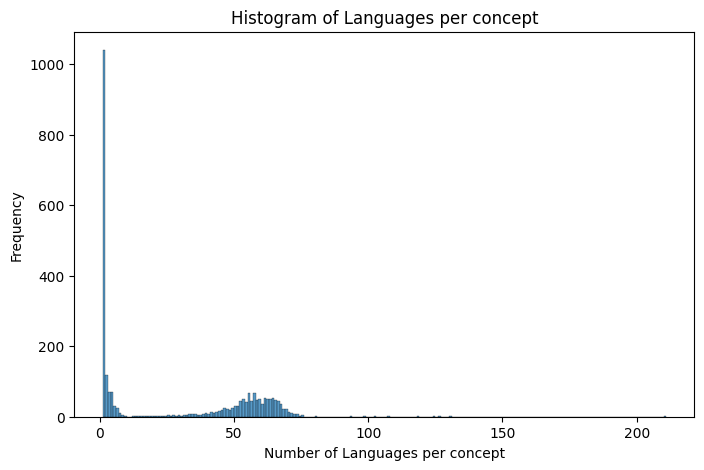

In [174]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
sns.histplot(concept_counts, bins=range(concept_counts.min(), concept_counts.max() + 2), kde=False, edgecolor='black')
plt.xlabel('Number of Languages per concept')
plt.ylabel('Frequency')
plt.title('Histogram of Languages per concept')
plt.show()

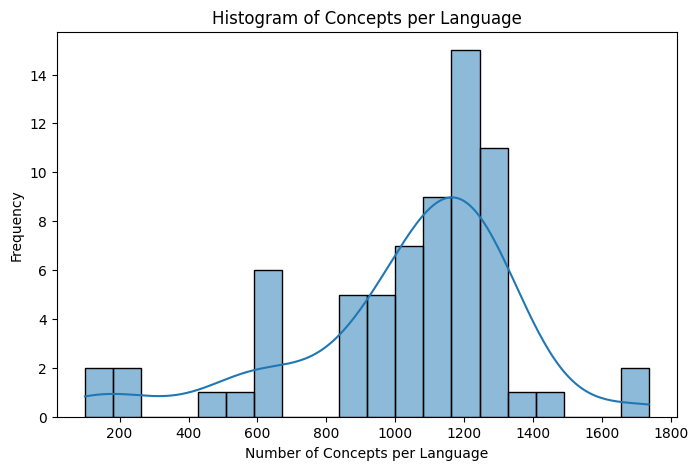

In [175]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
sns.histplot(language_counts, bins=20, kde=True, edgecolor='black')
plt.xlabel('Number of Concepts per Language')
plt.ylabel('Frequency')
plt.title('Histogram of Concepts per Language')
plt.show()

This is how we can convert the joined data in "thin" format to "wide" format. Note we have to remove duplicates to do so.

In [176]:
## joined_data_deduped = joined_data.copy().drop_duplicates(['Concept','Language'])
## pivoted_data = joined_data_deduped.pivot(index='Concept', columns='Language', values='Word')

In [177]:
##pivoted_data.head()

In [178]:
print(colnames["Abui Mobyetang"])
print(colnames["Mawesdai"])
print(colnames["Ivatan Isabtangan"])

['English', 'Indonesian', 'Abui_Mobyetang', 'Semantic Sphere']
['English', 'Indonesian', 'IPA', 'Mawesdai', 'Semantic field']
['English', 'Tagalog', 'Ivatan_Isabtangen', 'IPA']


## Extracting information about columns

This is a tricky bit! Lets look at what the columns look like:

We see that English is often here, IPA appears in both our choices. The target language appears too, and 'Semantic something' with no consistency.

We will now count everything to see what broader patterns there are. This is done by making a list of all of the values that we see:

In [179]:
values_as_list = []
for sublist in colnames.values():
    values_as_list.extend(sublist)

In [180]:
## If we just want the unique values we can use the python function 'set' which gets rid of duplicates for us.
unique_cols=list(set(values_as_list))

We will now count the number of occurances of each column.

In [181]:
from collections import Counter
# Create a Counter object to count occurrences
counter_obj = Counter(values_as_list)

We expect that each studied language will appear exactly once, whilst IPA and English would ideally be present in every case. Indonesian should be there for every Indonesian language, and we would also expect semantic field information too.

In [182]:
# This is a nice way to present the counts.
for item, count in counter_obj.items():
    if count > 1:
        print(f"{item}: {count}")

English: 68
Indonesian: 36
IPA: 9
Semantic Sphere: 4
ENGLISH ELICITATION NOTES: 7
Tagalog: 51
CEBUANO: 5
Kamayo: 2
Talaandig: 2
Semantic_Field: 23
English elicitation notes: 20
Indonesian elicitation notes: 16
Cebuano: 14
Tagalog Elicitation Notes: 3
Ontology: 3
Ilocano: 11
Local Orthography: 3
Hiligaynon: 2
NO.: 2
Kelon: 2
Sangil: 2


This implies we need to tidy up. Several minor languages appear wtwoce, and we have incomplete IPA and Semantic_Field information. We should however be able to join on the 'English' field.

## Ending: tidying up

There are lots of possible problems with the data.

In [183]:
def split_and_join_column(df,splitcol,s='[~]',strip=True):
    ## Split a dataframe column into multiple rows
    ## Specified in the format required by pandas.Series.str.split
    ## and optionally remove any created whitespace
    df[splitcol] = df[splitcol].str.split(s)
    df = df.explode(splitcol).reset_index(drop=True)
    cols = list(df.columns)
    df = df[cols]
    if strip:
        df[splitcol]=df[splitcol].str.strip()
    return df

In [184]:
def split_dataframe_by_regexp(df,col,regexp,regex=True):
    # Create a boolean mask for rows with quotes
    has_match = df[col].str.contains(regexp, regex=regex)
    # Separate into two DataFrames
    df_clean = df[~has_match].copy()     # rows without quotes
    df_concerns = df[has_match].copy()   # rows with quotes

    # Optional: report count
    print(f"Retaining {len(df_clean)} of {len(df)} rows.")
    return df_clean,df_concerns

In [185]:
joined_data_good=joined_data.copy()

In [186]:
test_good, test_bad = split_dataframe_by_regexp(joined_data_good,'Word','/',regex=False)
joined_data_good = split_and_join_column(joined_data_good,'Word','[~]')
test_good, test_bad = split_dataframe_by_regexp(joined_data_good,'Word','/',regex=False)

Retaining 70081 of 70249 rows.
Retaining 70130 of 70298 rows.


In [187]:
test_good, test_bad = split_dataframe_by_regexp(joined_data_good,'Word','/',regex=False)
joined_data_good = split_and_join_column(joined_data_good,'Word','[/]')
test_good, test_bad = split_dataframe_by_regexp(joined_data_good,'Word','/',regex=False)

Retaining 70130 of 70298 rows.
Retaining 70474 of 70474 rows.


In [188]:
joined_data_good, joined_data_bad = split_dataframe_by_regexp(joined_data_good,'Word',r"[\"]")
print(joined_data_bad)

Retaining 70474 of 70474 rows.
Empty DataFrame
Columns: [Concept, Word, Language]
Index: []


In [189]:
joined_data_good, joined_data_bad2 = split_dataframe_by_regexp(joined_data_good,'Word',"\t",regex=False)
print(joined_data_bad)

Retaining 70474 of 70474 rows.
Empty DataFrame
Columns: [Concept, Word, Language]
Index: []


In [190]:
test_good, test_bad = split_dataframe_by_regexp(joined_data_good,'Concept','/',regex=False)
joined_data_good['Concept'] = joined_data_good['Concept'].str.replace('/',';')
test_good, test_bad = split_dataframe_by_regexp(joined_data_good,'Concept','/',regex=False)

Retaining 70324 of 70474 rows.
Retaining 70474 of 70474 rows.


In [191]:
test_good, test_bad = split_dataframe_by_regexp(joined_data_good,'Concept','/',regex=False)
joined_data_good['Concept'] = joined_data_good['Concept'].str.replace('_x000D_',' ')
test_good, test_bad = split_dataframe_by_regexp(joined_data_good,'Concept','/',regex=False)

Retaining 70474 of 70474 rows.
Retaining 70474 of 70474 rows.


In [192]:
joined_data_good.loc[6583:6585,:]

,Concept,Word,Language
6583,if,kung,Akeanon
6584,or ; either_x000d_\n... or,o,Akeanon
6585,"still, yet",Sa gihapon,Akeanon


In [193]:
#joined_data_good['Concept']=[x.replace('ė', 'e') for x in joined_data_good['Concept']] # Doesn't match


### Saving the data

Finally, we'll save the most useful of these spreadsheets as new excel files.

In [194]:
## Annoyingly the 'to_excel' function doesn't handle True/False very well, so we'll make a duplicate that contains strings and save those.
englishsheet.replace({True: 'TRUE', False: 'FALSE'}).to_excel("OCSEAN_initial_englishsheet.xlsx")  
collectionsheet.replace({True: 'TRUE', False: 'FALSE'}).to_excel("OCSEAN_initial_collectionsheet.xlsx")

/var/folders/sd/6b6ndf8s69l3glyl3t0xl7zr0000gq/T/ipykernel_28458/2012373909.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  englishsheet.replace({True: 'TRUE', False: 'FALSE'}).to_excel("OCSEAN_initial_englishsheet.xlsx")


In [195]:
ocseandata=joined_data_good.rename(columns={"Concept": "concept", "Word": "form","Language": "doculect"}, errors="raise")
ocseandata["ID"]=ocseandata.index
ocseandata.head()
ocseandata.to_excel("OCSEAN_initial_joineddata.xlsx")
ocseandata.to_csv('OCSEAN_initial_joineddata.tsv',sep='\t')

In [196]:
##pivoted_data.to_excel("OCSEAN_initial_joineddata_pivoted_derived.xlsx")

In [197]:
testdata=ocseandata.loc[ocseandata['doculect']=="Ivatan_Ichbayatan"].copy()
testdata.loc[testdata['concept']=="pay"]

,concept,form,doculect,ID
37171,pay,paga,Ivatan_Ichbayatan,37171
37172,pay,mamaga,Ivatan_Ichbayatan,37172
